In [3]:
import torch
from IPython.display import display
from PIL import Image
import pandas as pd
import numpy as np
from rectpack import newPacker
import rectpack
import matplotlib.pyplot as plt
import warnings

import sys, os
sys.path.append(os.path.abspath('../'))
from utils.latex import crop_to_formula, renderedLaTeXLabelstr2Formula, display_formula
from data.datasets import renderedLaTeXDataset, set_seed
from transformers import TrOCRProcessor, VisionEncoderDecoderModel

/home/leon/anaconda3/envs/latexocr/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


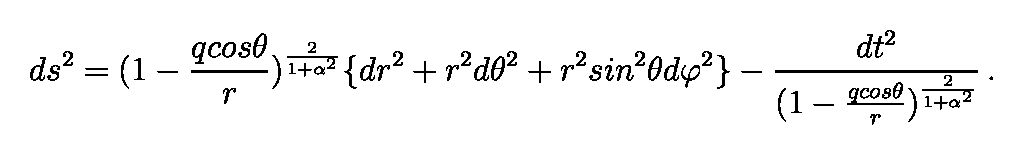

<IPython.core.display.Math object>

ds^{2} = (1 - {qcos\theta\over r})^{2\over 1 + \alpha^{2}}\lbrace dr^2+r^2d\theta^2+r^2sin^2\theta d\varphi^2\rbrace -{dt^2\over  (1 - {qcos\theta\over r})^{2\over 1 + \alpha^{2}}} .



In [4]:
image_num = 1

train_filenames_df = pd.read_csv("../rendered_LaTeX/im2latex_train.lst", sep=" ", index_col = 0, header = None)
formula_image_example = Image.open("../formula_images/" + train_filenames_df.loc[image_num, 1] + ".png").convert('RGBA')
formulas = open("../rendered_LaTeX/im2latex_formulas.lst", encoding = "ISO-8859-1", newline="\n").readlines()

display(crop_to_formula(formula_image_example))

display_formula(renderedLaTeXLabelstr2Formula(formulas[image_num]))
print(renderedLaTeXLabelstr2Formula(formulas[image_num]))

In [122]:
def generate_page(images, p_lines = .5, in_scale=200, paper_width=8.5, paper_height=11):
    """
    takes in a list of PIL images and returns an image with them pasted on
    and pixel wise bounding boxes describing the top left and bottom right
    coordinates of the equation on the paper of the form (x1,y1,x2,y2)
    """
    color_channel = 'RGBA'

    bounding_boxes =  [None] * len(images)
    img_sizes = [x.size + (i,) for i,x in enumerate(images)]


    scaled_width = int(in_scale * paper_width)
    scaled_height = int(in_scale * paper_height)
    # generates non-overlapping bounding boxes
    packer = newPacker(rotation=False, pack_algo=rectpack.GuillotineBafMaxas)
    packer.add_bin(scaled_width, scaled_height)

    for r in img_sizes:
        packer.add_rect(*r)
    packer.pack()
    
    paper = Image.new(color_channel, (scaled_width, scaled_height), color=(255,255,255,255)) # generate white rectangle

    if np.random.rand(1) < p_lines:
        # red line
        red_distance = int(1.25 * in_scale)
        red_line = Image.new(color_channel, (2, scaled_height), color=(255,0,0,255))
        paper.paste(red_line, (red_distance,0))

        # blue lines
        blue_height = (9 * in_scale) //32
        
    for rect in packer.rect_list():
        b, x, y, w, h, rid = rect

        bounding_boxes[rid] = (x, y, x+w, y+h)
        paper.paste(images[rid], (x,y), images[rid])
        
    return paper, bounding_boxes

In [123]:
processor = TrOCRProcessor.from_pretrained('microsoft/trocr-large-handwritten')
device = 'cpu'
train_ds = renderedLaTeXDataset(image_folder = "../formula_images/", 
                                lst_file = "../rendered_LaTeX/im2latex_train.lst", 
                                formulas_file = "../rendered_LaTeX/im2latex_formulas.lst", 
                                device = device,
                                processor = processor)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


In [124]:
images = []
for image_num in range(1,9):
    train_filenames_df = pd.read_csv("../rendered_LaTeX/im2latex_train.lst", sep=" ", index_col = 0, header = None)
    formula_image_example = Image.open("../formula_images/" + train_filenames_df.loc[image_num, 1] + ".png").convert('RGBA')

    img = crop_to_formula(formula_image_example)
    img = np.asarray(img.convert('RGBA')).copy()
    img[:, :, 3] = (255 * (img[:, :, :3] != 255).any(axis=2)).astype(np.uint8)
    img = Image.fromarray(img)

    images.append(img)

paper, boxes = generate_page(images, p_lines=1, in_scale=200)

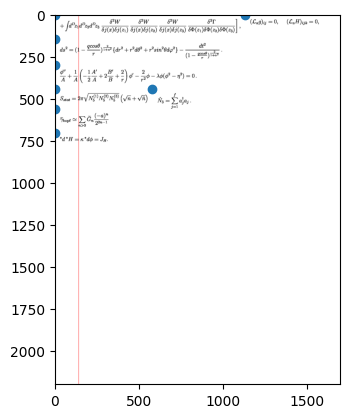

In [125]:
plt.imshow(paper)
plt.scatter([x[0] for x in boxes], [x[1] for x in boxes])